In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.ensemble import GradientBoostingClassifier
from boruta import BorutaPy
from sklearn.feature_selection import SelectFromModel
import xgboost

from IPython import display
display.set_matplotlib_formats('svg')

import shap
from sklearn.metrics import f1_score, confusion_matrix

In [2]:
df = pd.read_csv(r'C:\Users\SAS032\Documents\Python Scripts\20220630 PCM EXT vs INT Comparison\0630\PCM_Int_Ext_Tribo_FR_byWafer.csv')
df.shape

(672, 857)

In [3]:
df.head()

,WAFER,BUILD,Qty,MR_RES_HSA_P2,MR_RES_HSA_P98,MR_RES_HSA_median,MR_RES_HSA_std,TFC_RES_HSA_P2,TFC_RES_HSA_P98,TFC_RES_HSA_median,...,IB00_SER_ROLLER_MA_MAX_P2,IB00_SER_ROLLER_MA_MAX_P98,IB00_SER_ROLLER_MA_MAX_median,IB00_SER_ROLLER_MA_MAX_std,IB00_SER_ROLLER_MA_STD_P2,IB00_SER_ROLLER_MA_STD_P98,IB00_SER_ROLLER_MA_STD_median,IB00_SER_ROLLER_MA_STD_std,Tribo_FR,Qty_FR
0,0A31J,SAE,31,356.9448,550.3408,464.44,54.624520,99.9868,106.5012,102.62,...,-98.60,-75.00,-87.0,6.405978,2.0,7.80,4.0,1.700095,0.000769,39
1,0ACB1,SAE,94,324.3938,553.2804,409.00,59.344217,103.6980,112.9288,108.58,...,-106.14,-71.86,-89.0,8.542410,2.0,7.14,4.0,1.497500,0.000000,108
2,0ACB2,SAE,63,320.9520,539.0218,407.00,62.876620,105.7680,112.2696,109.00,...,-101.52,-75.00,-86.0,6.781990,2.0,8.00,3.0,1.630640,0.001806,72
3,0ACB4,SAE,214,334.6600,569.4280,433.33,59.960387,103.4340,111.6600,107.72,...,-103.00,-74.00,-88.5,7.455325,2.0,7.00,3.0,1.339361,0.003831,261
4,0ACBD,SAE,80,309.7160,577.8040,442.22,74.088230,101.2424,110.2900,105.96,...,-105.42,-74.32,-88.0,7.749071,2.0,7.00,4.0,1.440761,0.000000,97


In [4]:
df = df.loc[df.Tribo_FR>0]
df.shape

(441, 857)

In [5]:
df.drop(['Qty_FR', 'WAFER', 'Qty', 'Tribo_FR'], axis=1, inplace=True)
df.shape


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(441, 853)

In [6]:
df.isna().sum().sum()

0

In [31]:
df['BUILD'].value_counts()

FC5_SZ_x2_Bins    271
SAE               170
Name: BUILD, dtype: int64

In [33]:
df['BUILD'].replace({'SAE':0, 'FC5_SZ_x2_Bins':1}, inplace=True)
df['BUILD'].value_counts()

1    271
0    170
Name: BUILD, dtype: int64

In [268]:
df_copy = df.copy(deep=True)
drop_var = df_copy.columns[df_copy.columns.str.contains('RES_HSA|TFCEF|TFCFH|TRFITTC|ASYM|AMP|DHWP|ADAPKA|TFCRD|IVC_KC|ADAPIW|TWOPCPM|ABOAJPM|ABOFLAG|RVSUM|JINX_RV|TDP|RWSER_RW_SLP')]
df_copy.drop(drop_var, axis=1, inplace=True)
df_copy.shape

(441, 533)

In [269]:
X_train, X_test, y_train, y_test = train_test_split(df_copy.drop('BUILD', axis=1),
                                                   df_copy['BUILD'],
                                                   test_size=0.3,
                                                   random_state=10)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((308, 532), (133, 532), (308,), (133,))

### Feature Selection

#### 1. boruta

In [270]:
boruta = BorutaPy(estimator = GradientBoostingClassifier(),
                 n_estimators = 'auto',
                 max_iter = 100)
boruta.fit(X_train.values, y_train.values.ravel())

boruta_support = X_train.columns[boruta.support_].to_list()
boruta_support_weak = X_train.columns[boruta.support_weak_].to_list()

In [271]:
boruta_select = boruta_support + boruta_support_weak
len(boruta_select)

99

In [272]:
len(boruta_support), boruta_support

(11,
 ['U10N_MCWMD_P2',
  'U100_SNR_OD_std',
  'U300_SNR_MD_P98',
  'U101_RES1OD_P98',
  'U101_RES1MD_median',
  'U30N_PHY_R_MR_R1_median',
  'U30N_SER_AVG_P2',
  'U10N_IVC_OIV_08_median',
  'U31N_TROPCPM9_median',
  'SQZSER2R_OD_P2',
  'IB0N_OWPAV1OD_P98'])

#### 2. SelectFromModel

In [273]:
sel_ = SelectFromModel(GradientBoostingClassifier())
sel_.fit(X_train, y_train)

selected_feat = X_train.columns[sel_.get_support()]
len(selected_feat), selected_feat

(3,
 Index(['U101_MRWID_P2', 'U30N_SER_AVG_P2', 'U10N_IVC_OIV_08_median'], dtype='object'))

In [274]:
model = xgboost.XGBClassifier(n_estimators=100, max_depth=2).fit(X_train[boruta_support], y_train)
y_train_pred = model.predict(X_train[boruta_support])
y_test_pred = model.predict(X_test[boruta_support])

print('Training F1:{:.2f}'.format(f1_score(y_train, y_train_pred)))
print('Testing F1:{:.2f}'.format(f1_score(y_test, y_test_pred)))

[10:15:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training F1:1.00
Testing F1:1.00


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [275]:
print('Training confusion_matrix:\n', confusion_matrix(y_train, y_train_pred))
print('Testing confusion_matrix:\n', confusion_matrix(y_test, y_test_pred))

Training confusion_matrix:
 [[116   0]
 [  0 192]]
Testing confusion_matrix:
 [[54  0]
 [ 0 79]]


In [276]:
X_int = df.loc[df.BUILD==1].drop(['BUILD'], axis=1)[boruta_support]
X_int.shape

(271, 11)

In [277]:
# explain the GAM model with SHAP
explainer = shap.Explainer(model, X_train[boruta_support])
shap_values = explainer(X_int)

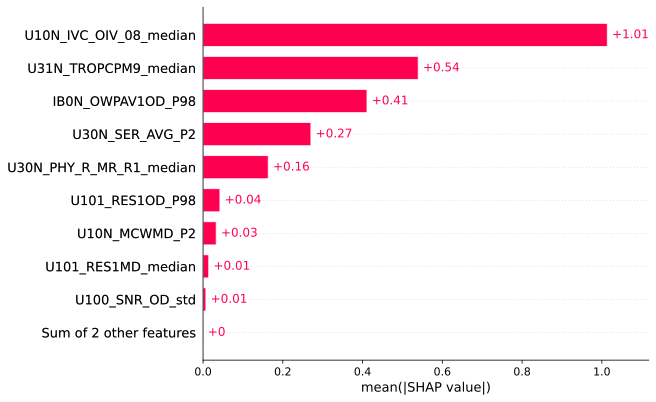

In [278]:
shap.plots.bar(shap_values) 

In [67]:
X_int.head()

,TFC_RES_HSA_median,U31N_TRFITTC1_median,U10N_TFCEF00_P2,U10N_TFCEF31_P98,U10N_ZEROTFCFH31_P2,U10N_ZEROTFCFH31_median,U30N_ADAPKA_0_P98,U30N_ADAPIW_6_P98,U30N_ADAPKA_6_P2,U10N_IVC_KC_02_P2,...,U10N_IVC_KC_06_median,U30N_TWOPCPM9_median,U100_TSTAT_TRFITTC1_P2,U300_MAXRVSUMHEAD_NRM_P2,S900_RVSUM_ZONE0_HOT_P2,S900_RVSUM_ZONE0_NRM_median,S900_MAXRVSUMHEAD_HOT_median,S900_MAXRVSUMHEAD_NRM_P2,S905_MAX_JINX_RV_P98,TDP_OD_P2
330,64.72,549.0,54.00,59.82,6894.54,7500.0,35.0,60.0,21.0,-352.64,...,-345.0,810.0,495.16,351.22,439.70,740.0,1117.0,408.88,4593.92,81.1800
338,63.92,517.0,53.06,61.94,6637.24,7143.5,38.0,61.0,22.0,-340.64,...,-347.0,820.0,481.18,432.76,582.04,700.0,1070.0,500.00,3532.04,79.2264
339,64.01,536.0,54.00,60.00,6590.32,7290.0,38.0,61.0,21.0,-347.52,...,-342.0,810.0,470.96,332.00,418.10,710.5,1050.5,372.36,4016.76,77.7645
344,65.89,546.0,54.00,59.00,6683.86,7323.0,38.0,61.0,21.0,-347.00,...,-344.0,810.0,485.00,324.00,401.46,678.0,980.0,369.92,3686.94,80.3550
348,65.29,545.0,53.00,59.00,6744.88,7372.0,37.0,61.0,21.0,-341.00,...,-338.0,800.0,485.00,332.04,435.00,696.0,1038.5,391.84,3204.12,79.8666


In [279]:
# for i in range(10):
#     shap.plots.waterfall(shap_values[i])